In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
# Define dataset directory path
# Folder structure :
# data/
#     with_mask/
#     without_mask/

dataset_path = "data"
# List all folders inside dataset (classes)
classes = os.listdir(dataset_path)
print("Found Classes:", classes)

# Display how many images per class for sanity checking
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    print(f"{cls} -> {len(os.listdir(cls_path))} images")


Found Classes: ['without_mask', 'with_mask']
without_mask -> 3828 images
with_mask -> 3725 images


In [4]:
# Define target image size for the CNN
img_size = 128

data = []   # will store image data
labels = [] # will store corresponding labels (0 or 1)

# Loop through both class folders
for category in classes:
    folder_path = os.path.join(dataset_path, category)
    
    # Loop through each image inside the class folder
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        # Load image using cv2 (OpenCV reads in BGR format)
        img = cv2.imread(img_path)
        if img is None:   # skip corrupted images
            continue
        
        # Convert BGR → RGB for display consistency
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image to the desired CNN input size
        img = cv2.resize(img, (img_size, img_size))
        
        # Append to dataset
        data.append(img)
        
        # Assign numeric label: with_mask → 0, without_mask → 1
        labels.append(0 if category == "with_mask" else 1)

# Convert to numpy arrays for training
data = np.array(data) / 255.0  # Normalize pixel values (0-1)
labels = np.array(labels)

print("Dataset Loaded Successfully!")
print("Data Shape:", data.shape)
print("Labels Shape:", labels.shape)


Dataset Loaded Successfully!
Data Shape: (7553, 128, 128, 3)
Labels Shape: (7553,)


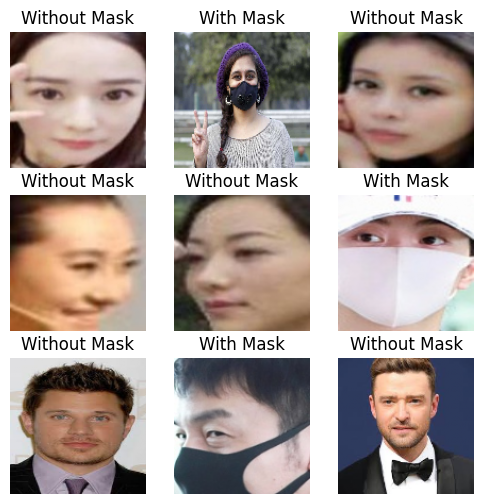

In [5]:
# Display 9 random sample images with class labels for verification

plt.figure(figsize=(6,6))
for i in range(9):
    idx = np.random.randint(0, len(data))  # random index
    plt.subplot(3, 3, i+1)
    plt.imshow(data[idx])  # show image
    plt.title("With Mask" if labels[idx] == 0 else "Without Mask")
    plt.axis('off')
plt.show()


In [6]:
# Split dataset into training and testing sets
# test_size = 0.2 means 20% of data will be used for testing
# shuffle=True randomizes data before splitting

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)


Training Data Shape: (6042, 128, 128, 3) (6042,)
Testing Data Shape: (1511, 128, 128, 3) (1511,)


In [10]:
# Define a Sequential CNN model

model = Sequential([
    
    # First convolution layer + pooling
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    # Second convolution layer + pooling
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third convolution layer + pooling
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten before feeding into Dense layers
    Flatten(),

    # Fully connected dense layer
    Dense(128, activation='relu'),
    
    # Dropout helps prevent overfitting
    Dropout(0.5),
    
    # Output layer (sigmoid for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile model with optimizer, loss and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # suitable for binary classification
    metrics=['accuracy']
)

# Print model architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ModelCheckpoint saves the best model (highest validation accuracy)
checkpoint = ModelCheckpoint(
    "mask_detector.h5", monitor='val_accuracy',
    save_best_only=True, verbose=1
)

# EarlyStopping stops training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


In [12]:
# Train the CNN model
# validation_split=0.2 means 20% of training data used for validation

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7085 - loss: 0.5513
Epoch 1: val_accuracy improved from None to 0.88586, saving model to mask_detector.h5



Epoch 1: finished saving model to mask_detector.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.8101 - loss: 0.3999 - val_accuracy: 0.8859 - val_loss: 0.2757
Epoch 2/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8965 - loss: 0.2622
Epoch 2: val_accuracy did not improve from 0.88586
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.8984 - loss: 0.2547 - val_accuracy: 0.8395 - val_loss: 0.3756
Epoch 3/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9081 - loss: 0.2296
Epoch 3: val_accuracy improved from 0.88586 to 0.92060, saving model to mask_detector.h5



Epoch 3: finished saving model to mask_detector.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.9183 - loss: 0.2087 - val_accuracy: 0.9206 - val_loss: 0.2012
Epoch 4/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9380 - loss: 0.1625
Epoch 4: val_accuracy did not improve from 0.92060
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9323 - loss: 0.1765 - val_accuracy: 0.9123 - val_loss: 0.2129
Epoch 5/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9437 - loss: 0.1516
Epoch 5: val_accuracy improved from 0.92060 to 0.92804, saving model to mask_detector.h5



Epoch 5: finished saving model to mask_detector.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9419 - loss: 0.1538 - val_accuracy: 0.9280 - val_loss: 0.1784
Epoch 6/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9560 - loss: 0.1215
Epoch 6: val_accuracy improved from 0.92804 to 0.93383, saving model to mask_detector.h5



Epoch 6: finished saving model to mask_detector.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9584 - loss: 0.1145 - val_accuracy: 0.9338 - val_loss: 0.1886
Epoch 7/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9653 - loss: 0.0938
Epoch 7: val_accuracy improved from 0.93383 to 0.95037, saving model to mask_detector.h5



Epoch 7: finished saving model to mask_detector.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9677 - loss: 0.0910 - val_accuracy: 0.9504 - val_loss: 0.1787
Epoch 8/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9775 - loss: 0.0626
Epoch 8: val_accuracy did not improve from 0.95037
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9783 - loss: 0.0611 - val_accuracy: 0.9438 - val_loss: 0.2019
Epoch 9/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9762 - loss: 0.0630
Epoch 9: val_accuracy did not improve from 0.95037
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9706 - loss: 0.0786 - val_accuracy: 0.9355 - val_loss: 0.2189
Epoch 10/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9781 - loss: 0.0600
Epoch 10: val_accuracy did not improve from 0.95037
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9791 - loss: 0.0557 - val_accuracy: 0.9413 - val_loss: 0.2546


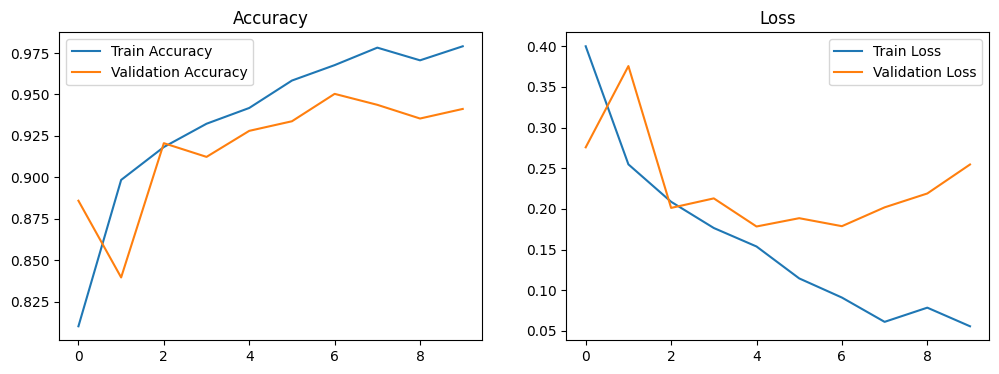

In [13]:
# Plot training and validation accuracy and loss over epochs

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()


In [14]:
# Evaluate performance on unseen test data

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9437 - loss: 0.1640
Test Accuracy: 94.37%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<>:46: SyntaxWarning: invalid escape sequence '\w'
<>:46: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5604\3920482191.py:46: SyntaxWarning: invalid escape sequence '\w'
  predict_mask("data\with_mask\with_mask_3706.jpg")  # replace with actual image path


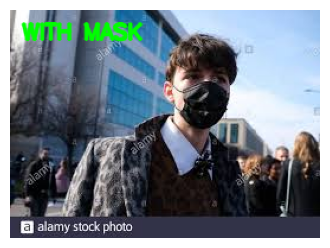

In [25]:
def predict_mask(img_path):
    """
    Function to predict if input image has mask or not.
    Uses the trained CNN model.
    """
    
    img = cv2.imread(img_path)  # load image
    if img is None:
        print("Invalid Path!")
        return
        
    # Convert BGR to RGB and resize
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    
    # Normalize and prepare for model
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    
    # Model prediction
    pred = model.predict(img_input)[0][0]
    
    # Label and color based on result
    label = "WITHOUT MASK" if pred > 0.5 else "WITH MASK"
    color = (255,0,0) if pred > 0.5 else (0,255,0)
    
    # Add smaller label text
    cv2.putText(
        img_rgb, 
        label, 
        (10, 25),                    # position
        cv2.FONT_HERSHEY_SIMPLEX,    # font
        0.6,                         # smaller fontScale
        color,                       # text color
        2,                           # thickness
        cv2.LINE_AA                  # smooth text
    )
    
    # Display image
    plt.figure(figsize=(4,4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Example usage of prediction function
predict_mask("data\with_mask\with_mask_3706.jpg")  # replace with actual image path